In [17]:
import tensorflow as tf

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import keras.backend as K
from keras.utils import load_img, img_to_array

from scipy.optimize import fmin_l_bfgs_b
import numpy as np
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()

In [8]:
def to_avgpool(shape, nconvs=None):
    '''
    Takes in the shape of the input.
    Returns a VGG model with all pooling step changed to average pooling instead of max pooling.
    nconvs, if used, should be an int that specify which layer we want to get from the model.
    '''
    if nconvs != None:
        assert(1<=nconvs<=13)
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    i = vgg.input
    x = i
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            x = AveragePooling2D()(x)
        else:
            x = layer(x)
    mod = Model(i, x)
    if nconvs == None:
        return mod
    output, n = None, 0
    for layer in mod.layers:
        if layer.__class__ == Conv2D:
            n += 1
        if n >= nconvs:
            output = layer.output
            break
    return Model(mod.input, output)

In [9]:
def img_scale(x):
    x -= x.min()
    return x / x.max()

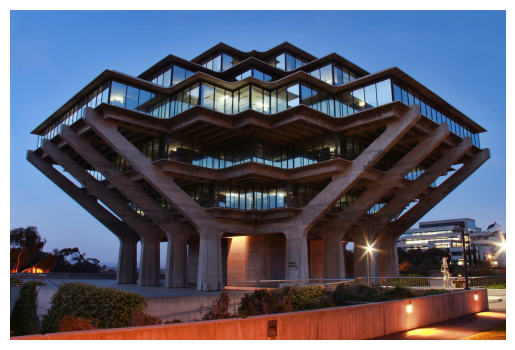

In [56]:
path = './geisel.jpg'
img = load_img(path)
plt.imshow(img)
plt.axis('off');

In [57]:
x = img_to_array(img)
x.shape

(681, 1023, 3)

In [58]:
x = np.expand_dims(x, 0)
x.shape

(1, 681, 1023, 3)

In [59]:
shape_batch = x.shape
shape_img = x.shape[1:]

In [60]:
mod_content = to_avgpool(shape_img, nconvs=3)
target = K.variable(mod_content.predict(x))
loss = K.mean(K.square(mod_content.output - target))
gradient = K.gradients(loss=loss, variables=mod_content.input)
lg_unwrapped = K.function(inputs=[mod_content.input], outputs=[loss]+gradient)

def lg(x):
    l, g = lg_unwrapped([x.reshape(*shape_batch)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_5:0", shape=(None, 681, 1023, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_5:0", shape=(None, 681, 1023, 3), dtype=float32)


In [61]:
from datetime import datetime
t0 = datetime.now()
ls = []
x = np.random.randn(np.prod(shape_batch))
iters = 10
for i in range(iters):
    x, l, _ = fmin_l_bfgs_b(func=lg, x0=x, maxfun=20)
    x = np.clip(x, -127, 127)
    print(f"Loss at {i}th iteration: {l}")
    ls.append(l)
print(f"Time taken: {datetime.now() - t0}")
plt.plot(ls)
plt.show()

img_out = x.reshape(*shape_img)
img_out[..., 0] += 103.939
img_out[..., 1] += 116.779
img_out[..., 2] += 126.68
img_out = img_out[..., ::-1]

plt.imshow(img_scale(img_out))
plt.show()



Loss at 0th iteration: 12661.5546875
Loss at 1th iteration: 7241.17724609375


KeyboardInterrupt: 

In [ ]:
img_out.shape

(681, 1023, 3)

In [ ]:
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Title</title>

    <style>
    	#video {
    		transform: rotateY(180deg);
    		-webkit-transform:rotateY(180deg); /* Safari and Chrome */
    		-moz-transform:rotateY(180deg); /* Firefox */
    		
    	}
    </style>
    
     <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.5.1/jquery.min.js"></script>
     <script src='https://cdnjs.cloudflare.com/ajax/libs/socket.io/2.0.0/socket.io.js'></script>
</head>

<body>

    <div id="container">
    <video autoplay playsinline id="videoElement"></video>
    <canvas id="canvas"  width="400" height="300"></canvas>
    </div>

    <div class = 'video'>
        <img id="photo"  width="400"  height="300">
        <h1>video</h1>
    </div>

    <script type="text/javascript" charset="utf-8">
      
        var socket = io.connect(window.location.protocol + '//' + document.domain + ':' + location.port);
        socket.on('connect', function(){
            console.log("Connected...!", socket.connected)
        });


        var canvas = document.getElementById('canvas');
        var context = canvas.getContext('2d');
        const video = document.querySelector("#videoElement");

        video.width = 400;
        video.height = 300; 
    

        if (navigator.mediaDevices.getUserMedia) {
            navigator.mediaDevices.getUserMedia({ video: true })
            .then(function (stream) {
                video.srcObject = stream;
                video.play();
            })
            .catch(function (err0r) {

            });
        }

        const FPS = 6;
        setInterval(() => {
            width=video.width;
            height=video.height;
            context.drawImage(video, 0, 0, width , height );
            var data = canvas.toDataURL('image/jpeg', 0.5);
            context.clearRect(0, 0, width,height );
            socket.emit('image', data);
        }, 1000/FPS);

        socket.on('response_back', function(image){
                photo.setAttribute('src', image );
                
        });

    </script>


 </body>

</html>

In [63]:
import pip, os, time

for package in pip.get_installed_distributions():
     print("%s: %s" % (package, time.ctime(os.path.getctime(package.location))))

/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


AttributeError: module 'pip' has no attribute 'get_installed_distributions'

In [64]:
import pkg_resources

dists = [d for d in pkg_resources.working_set]

In [66]:
dists

[flatbuffers 20210226132247 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 certifi 2022.9.24 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 pytz 2022.6 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 setuptools 65.5.0 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 cryptography 38.0.1 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 pyzmq 24.0.1 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 pip 22.2.2 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 attrs 22.1.0 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 pyOpenSSL 22.0.0 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 argon2-cffi 21.3.0 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 packaging 21.3 (/Users/liuboyong/opt/anaconda3/envs/jntm/lib/python3.8/site-packages),
 argon2-cffi-b

In [69]:
'a:b:c'.split(':', 1)[1]

'b:c'